### Pre-Processing

First we need to import the os and pandas modules. The os module is used to bring in data from text files stored in the local directories, and pandas is used to create DataFrames for analysis and data presentation.

In [1]:
# import string
import os
import pandas as pd

Now we need to bring in the data found at <https://cblevins.github.io/f19-dig-hist/homework/week-06-homework/>. The data is in the form of a separate text file for each journal entry from the years 1804 and 1805.

We use the os module to generate a list in python containing each text file name as an element of the list.

We also set pandas to display all rows of any future DataFrames at this point.

In [3]:
pd.set_option('display.max_rows', None)
# os.chdir(r"C:\Users\tmitc\notebooks\mini-project\diary") # need to make this path relative to current notebooks directory
os.chdir('./diary')
year_1804 = []
year_1805 = []

all_entries = os.listdir()

With all the file names in our list, we loop through the list and read the text from each entry into new lists, one for 1804 and one for 1805. This is where we do some cleaning up of the data by removing the '\#' and '$' characters and converting the entire text into lower case.

In [4]:
for f in all_entries:
    if f.startswith('1804'):
        entry = open(f, "r")
        year_1804.append(entry.read().lower().replace('#', '').replace('$', ''))
    elif f.startswith('1805'):
        entry = open(f, "r")
        year_1805.append(entry.read().lower().replace('#', '').replace('$', ''))

### Creating the Data Set

Now we create our DataFrame. Each row is an entry in the diary, and the only column so far is the actual text for that day.

In [13]:
entries_df = pd.DataFrame(year_1804.extend(year_1805), columns=["Text"])

print(year_1805)

['clear. i went to son ephraim*s, find them as well as they have lately been, tarry yesterday night. at son ephraim*s.', 'clear morn, shower the middle of the day. i have taken down my bed slead to clean it of bugs, skolt ye sealing and washt the floor. le faett is gone to samuel pierce*s. at home.', 'clear. i have been mending cloaths for son cyrus. mrs babcock & pierce, daughter ballard & mr coner took tea with me. at home. i lransplanted musk mellions.', 'cloudy & showers. sister barton and i went to son ephraim*s. i left her there and returnd home at evening. we calld at peris, hamlin*s & amos partridge*s. i calld at shubael pitts*s, bot candles and snuff. at son ephraim*s. sister barton with me.', 'a little rain fore n, clear afternoon. mr ballard returnd home, i did not. the 2 youngest children unwel. at ditto.', 'clear and pleast [but] bad walking. mr ballard to meeting. mr gray sleeps here, he preacht at captain banger*s. at home. mr gray slept here.', 'clear. son jonathan had 

This is where the bulk of our data work occurs. We need to generate a true/false boolean for each day for the following weather types: clear, warm, cloudy, snow, cold, windy, and raining. We read the text entry of each column and search for 1 or more keywords associated with each weather type, filling in true if found and false if not.

Because Martha Ballard put a description of the weather at the beginning of each diary entry, it was easy to find days where we had generated no true values for these weather types and determine if there was an error causing no weather to be found. This is how we identified common synonyms or misspellings that she used.

We also counted the number of times each day that she mentioned a word relating to sickness: 'ill', 'unwell', or 'sick'.

The last part is quantifying the weather for data analysis. Because we are primarily focused on bad weather, we decided to have a 'Bad Weather' column that gets a count of 1 for each column of Snow, Cold, or Raining that was true for that day. For example, a cold and rainy day would get a value of 2, whereas a cold day would only be a value of 1. One note is that when generating the true/false values for the weather, we considered a snowy day to automatically be cold, even if Martha did not explicitly mention the cold for that snowy day.

In [11]:
entries_df['Clear'] = entries_df.Text.str.contains('clear')
entries_df['Warm'] = entries_df.Text.str.contains('warm')
entries_df['Cloudy'] = entries_df.Text.str.contains('cloud')
entries_df['Snow'] = entries_df.Text.str.contains('snow')
entries_df['Cold'] = entries_df.Text.str.contains('|'.join(['cold', 'chill', 'snow', 'cool']))
entries_df['Windy'] = entries_df.Text.str.contains('|'.join(['wind', 'blowd', 'gust', 'blowed']))
entries_df['Raining'] = entries_df.Text.str.contains('|'.join(['rain', 'shower']))
entries_df['Bad Weather'] = entries_df.Snow.astype(int) + entries_df.Raining.astype(int) + entries_df.Cold.astype(int)
entries_df['Sick Count'] = entries_df.Text.str.count('sick') + entries_df.Text.str.count('unwel') + entries_df.Text.str.count('ill')
entries_df

,Text,Clear,Warm,Cloudy,Snow,Cold,Windy,Raining,Bad Weather,Sick Count


### Analysis

We wanted to analyze the relationship between inclement weather and the general quantity of sick people mentioned in the diary. Instead of keeping the data in a daily form, we decided to group the 'sick counts' and 'bad weather counts' into weeks, where the value for each week would simply be the sum of the counts for the 7 days in the week.

To do this we create a second DataFrame that loops through the first DataFrame and adds the rows for each week along the way.

In [7]:
def get_weekly_totals(df):
    records = []
    for i in range(52):
        bad_weather_total = 0
        sick_total = 0
        week = i + 1
        
        for j in range(7):
            bad_weather_total += df.iloc[(i * 7) + j]['Bad Weather']
            sick_total += df.iloc[(i * 7) + j]['Sick Count']
        
        records.append([week, bad_weather_total, sick_total])
    
    return pd.DataFrame.from_records(records, columns=['Week', 'Bad Weather', 'Sick'])

weekly = get_weekly_totals(entries_df)
weekly

,Week,Bad Weather,Sick
0,1,1,4
1,2,2,1
2,3,1,2
3,4,2,2
4,5,3,0
5,6,1,1
6,7,4,3
7,8,1,2
8,9,5,2
9,10,4,1


Now we create a bar graph that plots the counts for sickness and bad weather on the same graph, using the week number as the x-axis. We also adjust some settings to make it easier to visualize

<AxesSubplot:>

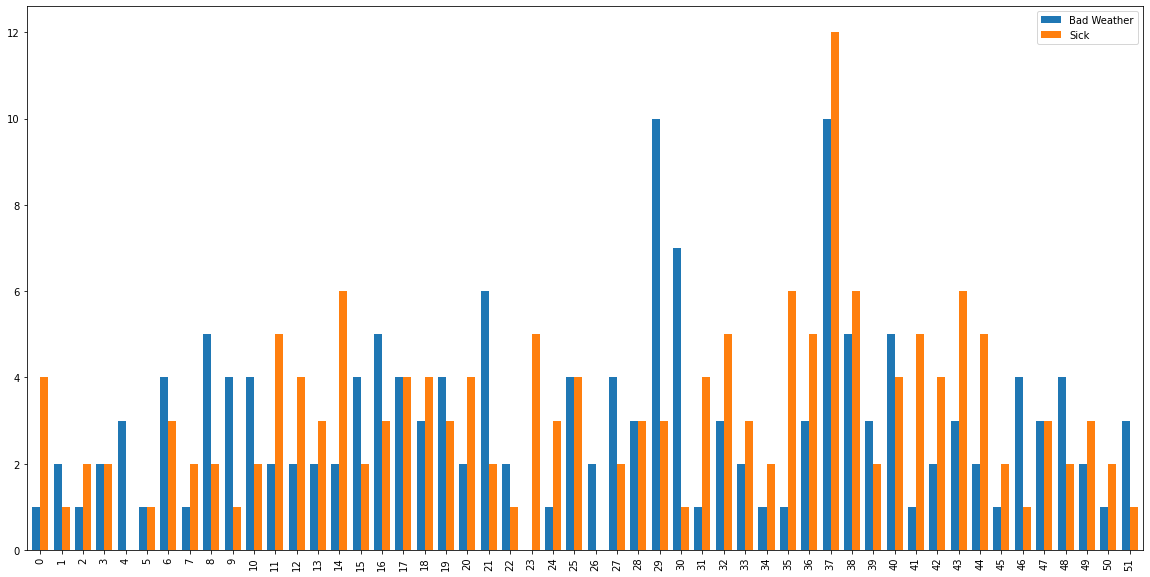

In [8]:
weekly[['Bad Weather', 'Sick']].plot(kind='bar', figsize=(20, 10), width=0.75)